# Health Markers SQL Analysis

## Objective

To analyze clinical health markers using SQL-driven analytics
and answer the following business questions:

1. How do biomarker averages differ by health condition?
2. What is the distribution of glucose and HbA1C across conditions?
3. What proportion of patients are high risk?
4. Does data quality vary by condition?
5. Which biomarkers show strongest separation between conditions?

This notebook emphasizes SQL-first analytics with Python visualization.


In [3]:
## Creating database connection
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
conn = sqlite3.connect("../data/Health_markers_datasets.db")

In [4]:
tables = pd.read_sql_query("SELECT name From sqlite_master WHERE type='table'",conn)
tables

,name
0,health_markers_dataset
1,health_markers_raw
2,health_markers_curated
3,health_markers_analytics
4,etl_metadata


In [11]:
##Checking the metadata table   
df= pd.read_sql("select * from etl_metadata", conn)
df

,run_timestamp,rows_processed,pipeline_version,source_table
0,2026-02-15 16:42:07.192978,25000,v1.0,Health_markers_dataset


### 1: Biomarker Comparison by Condition
Do diabetic patients show statistically higher glucose and HbA1C?

In [19]:
query = """
SELECT
    Condition,
    COUNT(*) AS total_patients,
    ROUND(AVG(Blood_glucose),2) AS avg_glucose,
    ROUND(AVG(HbA1C),2) AS avg_hba1c,
    ROUND(AVG(Systolic_BP),2) AS avg_sys_bp,
    ROUND(AVG(LDL),2) AS avg_ldl
FROM health_markers_analytics
GROUP BY Condition
ORDER BY avg_hba1c DESC;
"""

df_condition_summary = pd.read_sql_query(query, conn)
df_condition_summary


,Condition,total_patients,avg_glucose,avg_hba1c,avg_sys_bp,avg_ldl
0,Diabetes,3052,160.64,7.75,109.67,95.21
1,Hypertension,1757,94.38,5.21,155.04,95.11
2,Anemia,868,95.23,5.20,109.87,94.45
3,High_Cholesterol,1323,94.05,5.19,109.31,195.91
4,Fit,18000,94.70,5.19,109.56,94.93


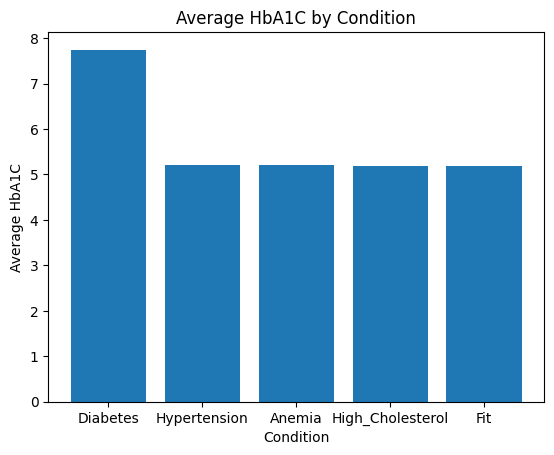

In [20]:
plt.figure()
plt.bar(df_condition_summary["Condition"],
        df_condition_summary["avg_hba1c"])
plt.title("Average HbA1C by Condition")
plt.xlabel("Condition")
plt.ylabel("Average HbA1C")
plt.show()

### 2: Glucose Distribution Ranking
Which patients show extreme glucose levels?

In [21]:
query = """
SELECT *
FROM (
    SELECT *,
           RANK() OVER (
               PARTITION BY Condition
               ORDER BY Blood_glucose DESC
           ) AS glucose_rank
    FROM health_markers_analytics
)
WHERE glucose_rank <= 5;
"""

df_top_glucose = pd.read_sql_query(query, conn)
df_top_glucose.head()

,Blood_glucose,HbA1C,Systolic_BP,Diastolic_BP,LDL,HDL,Triglycerides,Haemoglobin,MCV,Condition,glucose_rank
0,118.97,4.48,104.77,73.88,95.86,51.33,143.48,7.09,70.15,Anemia,1
1,118.78,4.15,124.36,71.11,130.67,57.69,135.45,6.54,78.11,Anemia,2
2,118.77,5.91,113.34,60.70,101.42,41.02,164.32,7.15,72.20,Anemia,3
3,118.70,5.90,120.46,70.51,69.76,41.23,77.14,10.52,78.14,Anemia,4
4,118.67,6.23,115.98,61.12,58.09,51.27,123.69,7.29,62.09,Anemia,5


### 3: High-Risk Proportion

What percentage of patients are clinically high risk?

In [22]:
query = """
SELECT
    Condition,
    COUNT(*) AS total,
    SUM(CASE
            WHEN HbA1C >= 6.5
                 OR Systolic_BP >= 140
                 OR LDL >= 160
            THEN 1 ELSE 0 END) AS high_risk_count,
    ROUND(
        100.0 * SUM(
            CASE
                WHEN HbA1C >= 6.5
                     OR Systolic_BP >= 140
                     OR LDL >= 160
                THEN 1 ELSE 0 END
        ) / COUNT(*), 2
    ) AS high_risk_percentage
FROM health_markers_analytics
GROUP BY Condition;
"""

df_risk = pd.read_sql_query(query, conn)
df_risk


,Condition,total,high_risk_count,high_risk_percentage
0,Anemia,868,0,0.00
1,Diabetes,3052,3052,100.00
2,Fit,18000,0,0.00
3,High_Cholesterol,1323,1089,82.31
4,Hypertension,1757,1381,78.60


### 4: Data Quality Assessment
Does data quality differ across health conditions?

In [23]:
query = """
SELECT
    Condition,
    ROUND(AVG(quality_score),2) AS avg_quality_score,
    ROUND(AVG(invalid_count),2) AS avg_invalid_values,
    ROUND(AVG(outlier_count),2) AS avg_outliers
FROM health_markers_curated
GROUP BY Condition;
"""

df_quality = pd.read_sql_query(query, conn)
df_quality


,Condition,avg_quality_score,avg_invalid_values,avg_outliers
0,Anemia,95.75,0.0,1.32
1,Diabetes,96.90,0.0,0.96
2,Fit,99.68,0.0,0.00
3,High_Cholesterol,94.72,0.0,1.71
4,Hypertension,95.41,0.0,1.45


### 5: Correlation Preparation
Which biomarkers are strongly correlated?

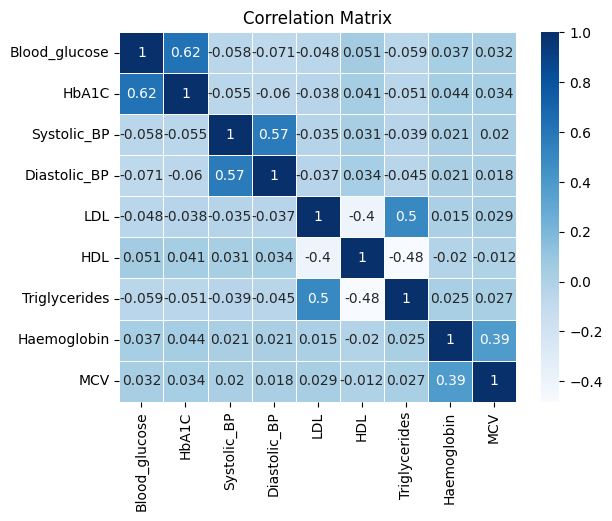

In [24]:
query = """
SELECT
    Blood_glucose,
    HbA1C,
    Systolic_BP,
    Diastolic_BP,
    LDL,
    HDL,
    Triglycerides,
    Haemoglobin,
    MCV
FROM health_markers_analytics
;
"""

df_corr = pd.read_sql_query(query, conn)
corr = df_corr.corr()

##plt.figure(figsize=(8,6))
sns.heatmap(df_corr.corr(), annot=True, cmap='Blues',linewidths=0.5)

plt.title("Correlation Matrix")
plt.show()


## Executive Summary – SQL Analysis

### 1. Condition-Level Patterns

SQL aggregation shows clear biomarker differentiation:

- **Diabetes** → Highest Blood Glucose (160.64) and HbA1C (7.75)  
- **Hypertension** → Highest Systolic BP (155.04)  
- **High_Cholesterol** → Highest LDL (195.91)  
- **Fit** → Stable averages across biomarkers  

The dataset reflects clinically consistent group-level behavior.

---

### 2. High-Risk Segmentation (Rule-Based)

Based on defined clinical thresholds:

- **Diabetes** → 100% high-risk  
- **High_Cholesterol** → 82.31%  
- **Hypertension** → 78.60%  
- **Anemia & Fit** → 0%  

Risk classification aligns logically with disease categories.

---

### 3. Data Quality Assessment

- Average quality scores exceed **94** across all conditions  
- No invalid clinical values detected  
- Minimal impact from outliers  

Overall data integrity is consistent across groups.

---

### 4. Feature Relationships (Descriptive)

Observed linear correlations:

- Glucose ↔ HbA1C: **0.62**  
- Systolic ↔ Diastolic BP: **0.57**  
- LDL ↔ Triglycerides: **0.50**  
- HDL shows inverse relation with LDL and Triglycerides  

These findings are descriptive and not inferential.

---

## Transition to Full EDA

This SQL stage establishes structural validity and biomarker differentiation.

The next phase will focus on:

- Outlier treatment
- Statistical significance testing  
- Distribution analysis  
- Variance comparison  
- Feature preparation for modeling  
